## Imports and Miscellaneous

In [1]:
!pip install seaborn

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
import warnings
from joblib import Parallel, delayed, parallel_backend, parallel_config
from pathlib import Path
import time
import multiprocessing
import pickle
import json
import os
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", FutureWarning)
%config Application.warn_ignores = FutureWarning

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 16


## Notebook Start Time

In [3]:
notebook_start_time = time.time()

## Data

In [4]:
def create_mem_map(parquet_file, data_type='train'):
   
    df = pd.read_parquet(parquet_file)
    scaler = MinMaxScaler()
    
    mem_map_dir = Path('./mem_map_files')
    mem_map_dir.mkdir(exist_ok=True)
    
    mem_map_file_X = mem_map_dir / f'X_{data_type}.npy'
    mem_map_file_X_scaled = mem_map_dir / f'X_{data_type}_scaled.npy'
    mem_map_file_y_2 = mem_map_dir / f'y_{data_type}_2.npy'
    mem_map_file_y_6 = mem_map_dir / f'y_{data_type}_6.npy'
    mem_map_file_y_19 = mem_map_dir / f'y_{data_type}_19.npy'
    
    X = df.drop(columns=['label', 'class_label', 'category_label', 'attack_label']).to_numpy()
    np.save(mem_map_file_X, X)  

    X_scaled =  scaler.fit_transform(X)
    np.save(mem_map_file_X_scaled, X_scaled) 
    
    encoder_2 = LabelEncoder()
    encoder_6 = LabelEncoder()
    encoder_19 = LabelEncoder()

    y_2 = encoder_2.fit_transform(df['class_label'])  
    y_6 = encoder_6.fit_transform(df['category_label'])  
    y_19 = encoder_19.fit_transform(df['attack_label']) 
    
    np.save(mem_map_file_y_2, y_2)
    np.save(mem_map_file_y_6, y_6)
    np.save(mem_map_file_y_19, y_19)

    np.save(mem_map_dir / f'encoder_2_classes.npy', encoder_2.classes_)
    np.save(mem_map_dir / f'encoder_6_classes.npy', encoder_6.classes_)
    np.save(mem_map_dir / f'encoder_19_classes.npy', encoder_19.classes_)

In [5]:
mem_map_created = True

if mem_map_created == False:
    create_mem_map('./data/cic_iomt_2024_wifi_mqtt_train.parquet', data_type='train')
    create_mem_map('./data/cic_iomt_2024_wifi_mqtt_test.parquet', data_type='test')
    

In [6]:
mem_map_dir = Path('./mem_map_files')
X_train = np.load(mem_map_dir / 'X_train.npy', mmap_mode='r')
#X_train_scaled = np.load(mem_map_dir / 'X_train_scaled.npy', mmap_mode='r')

y_train_2 = np.load(mem_map_dir / 'y_train_2.npy', mmap_mode='r')
y_train_6 = np.load(mem_map_dir / 'y_train_6.npy', mmap_mode='r')
y_train_19 = np.load(mem_map_dir / 'y_train_19.npy', mmap_mode='r')


X_test = np.load(mem_map_dir / 'X_test.npy', mmap_mode='r')
#X_test_scaled = np.load(mem_map_dir / 'X_test_scaled.npy', mmap_mode='r')

y_test_2 = np.load(mem_map_dir / 'y_test_2.npy', mmap_mode='r')
y_test_6 = np.load(mem_map_dir / 'y_test_6.npy', mmap_mode='r')
y_test_19 = np.load(mem_map_dir / 'y_test_19.npy', mmap_mode='r')

encoder_2_classes = np.load('./mem_map_files/encoder_2_classes.npy', allow_pickle=True)
encoder_6_classes = np.load('./mem_map_files/encoder_6_classes.npy', allow_pickle=True)
encoder_19_classes = np.load('./mem_map_files/encoder_19_classes.npy', allow_pickle=True)

In [7]:
n_features = X_train.shape[1]

## PSO Code

### Benchmark Function

In [8]:
def calculate_benchmark(X_train=None, X_test=None, y_train=None, y_test=None):
    
    classifier = RandomForestClassifier(n_estimators=10, max_depth=15, n_jobs=-1, random_state=1984)

    algo_start = time.time()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    algo_end = time.time()

    if np.unique(y_train).size == 2:
         report = classification_report(encoder_2_classes[y_test], encoder_2_classes[y_pred], output_dict=True)
    elif np.unique(y_train).size == 6:
        report = classification_report(encoder_6_classes[y_test], encoder_6_classes[y_pred], output_dict=True)
    else:
        report = classification_report(encoder_19_classes[y_test], encoder_19_classes[y_pred], output_dict=True)

    return report, algo_end - algo_start, y_pred

### Fitness Function

In [9]:
def fitness_function(position, X_train, X_test, y_train, y_test):

    start_time_selection = time.time()
    selected_features = np.where(position == 1)[0]
    if len(selected_features) == 0:
        return 0
    
    classifier = RandomForestClassifier(n_estimators=10, max_depth=15, n_jobs=1, random_state=1984)

    classifier.fit(X_train[:, selected_features], y_train)
    y_pred = classifier.predict(X_test[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

### PSO Feature Selection Function

In [10]:
def pso_feature_selection(num_particles=num_cores, num_iterations=20, n_features=n_features, min_improvement=0.0001, inertia_weight=0.5, cognitive_component=1.5, social_component=1.5, X_train=None, X_test=None, y_train=None, y_test=None, parallel=False, max_same=10):

    # PSO Initialization
    init_start = time.time()
    velocity = np.zeros(shape=(num_particles, n_features))
    current_position = np.random.randint(2, size=(num_particles, n_features))

    if parallel == True:
        with parallel_backend('loky'):
            current_fitness = np.array(Parallel(n_jobs=-1, batch_size=1, verbose=10)(delayed(fitness_function)(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])))
    else:
        current_fitness = np.array([fitness_function(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])])

    personal_best_position = np.copy(current_position)
    personal_best_fitness =  np.copy(current_fitness)
    global_best_position = personal_best_position[np.argmax(personal_best_fitness)]
    global_best_fitness = np.max(personal_best_fitness)
    init_end = time.time()
    print(f"Initialization time: {(init_end - init_start)/60:.2f} minutes")
 
    small_improvement = 0

    # Main PSO Loop
    for iteration in range(num_iterations):
        iteration_start = time.time()
        prior_global_best_fitness = np.copy(global_best_fitness)
        print(f"Iteration {iteration + 1}/{num_iterations}")
        if parallel == True:
            with parallel_backend('loky'):
                current_fitness = np.array(Parallel(n_jobs=-1, batch_size=1, verbose=10)(delayed(fitness_function)(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])))
        else:
            current_fitness = np.array([fitness_function(current_position[i, :], X_train, X_test, y_train, y_test) for i in range(current_position.shape[0])])
            
        fitness_map = current_fitness > personal_best_fitness
        personal_best_fitness[fitness_map] = current_fitness[fitness_map]
        personal_best_position[fitness_map] = current_position[fitness_map]
        global_best_position = personal_best_position[np.argmax(personal_best_fitness)]
        global_best_fitness = np.max(personal_best_fitness)
        print(f"Global Best Fitness: {global_best_fitness:.4f}")

        if (global_best_fitness - prior_global_best_fitness) < min_improvement:
            small_improvement +=1
        else:
            small_improvement = 0

        if small_improvement >= max_same:
            iteration_end = time.time()
            print(f"Iteration time: {(iteration_end - iteration_start)/60:.2f} minutes")
            return global_best_position, global_best_fitness

        r1 = np.random.rand(num_particles, n_features)
        r2 = np.random.rand(num_particles, n_features)
        velocity = inertia_weight * velocity + cognitive_component * r1 * (personal_best_position - current_position) + social_component * r2 * (global_best_position - current_position)
        rand_nums = np.random.rand(num_particles, n_features)
        flip_probs = 1 / (1 + np.exp(-velocity))
        flip_map = rand_nums <= flip_probs
        current_position = np.where(flip_map,1,0)
        iteration_end = time.time()
        print(f"Iteration time: {(iteration_end - iteration_start)/60:.2f} minutes")

    return global_best_position, global_best_fitness

### Random Forest

#### Binary

In [11]:
rf_pso_best_pos_2, rf_pso_best_fitness_2 = pso_feature_selection(X_train=X_train, X_test=X_test, y_train=y_train_2, y_test=y_test_2, parallel=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.0min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.3min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   32.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Initialization time: 2.97 minutes
Iteration 1/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.4min remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.72 minutes
Iteration 2/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.7min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   55.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.40 minutes
Iteration 3/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   31.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.55 minutes
Iteration 4/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  1.9min remaining:   51.2s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.42 minutes
Iteration 5/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.0min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   56.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.4min remaining:   32.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.51 minutes
Iteration 6/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   58.1s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.57 minutes
Iteration 7/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   54.1s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   31.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.39 minutes
Iteration 8/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   55.7s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9991
Iteration time: 2.82 minutes
Iteration 9/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.6min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.7min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  1.9min remaining:   52.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   28.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9992
Iteration time: 2.21 minutes
Iteration 10/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.3min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.5min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.6min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.7min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  1.8min remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  1.8min remaining:   25.4s


Global Best Fitness: 0.9992
Iteration time: 2.14 minutes


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


In [12]:
rf_pso_features_2 = np.sum(rf_pso_best_pos_2)
selected_features = np.where(rf_pso_best_pos_2 == 1)[0]
rf_pso_report_2, rf_pso_time_2, y_pred_rf_pso_2 = calculate_benchmark(X_train=X_train[:, selected_features], X_test=X_test[:, selected_features], y_train=y_train_2, y_test=y_test_2)
print(pd.DataFrame(rf_pso_report_2).transpose())
print(rf_pso_time_2)

              precision    recall  f1-score       support
Attack         0.999866  0.999279  0.999572  1.576575e+06
Benign         0.970493  0.994389  0.982296  3.760700e+04
accuracy       0.999165  0.999165  0.999165  9.991649e-01
macro avg      0.985179  0.996834  0.990934  1.614182e+06
weighted avg   0.999182  0.999165  0.999170  1.614182e+06
11.566552639007568


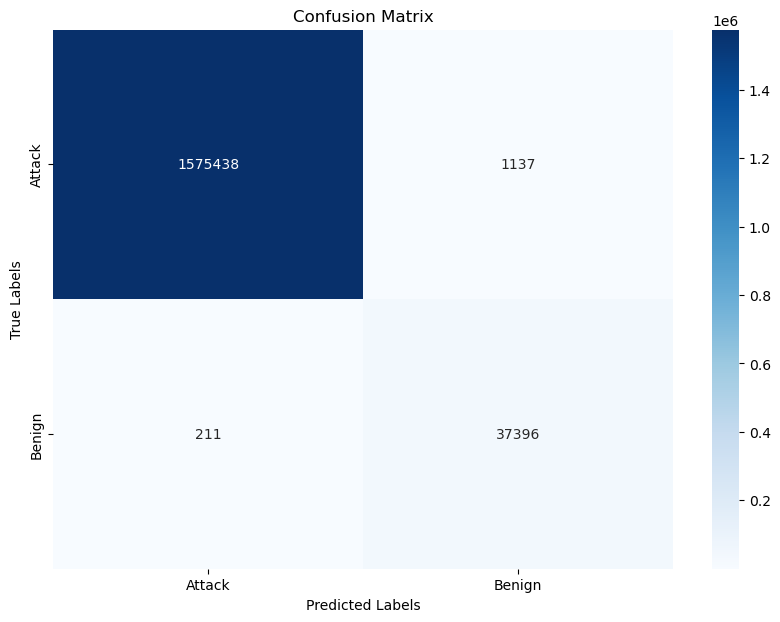

In [17]:
cm_rf_pso_2 = confusion_matrix(y_test_2, y_pred_rf_pso_2)

# get names for confusion matrix
df_2 = pd.DataFrame(rf_pso_report_2)
column_names_2 = df_2.columns.tolist()[0:2]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_pso_2,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_2,
            yticklabels=column_names_2)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 6 Classes

In [18]:
rf_pso_best_pos_6, rf_pso_best_fitness_6  = pso_feature_selection(X_train=X_train, X_test=X_test, y_train=y_train_6, y_test=y_test_6, parallel=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  2.2min remaining:  9.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.2min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.3min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.6min remaining:   35.6s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Initialization time: 2.80 minutes
Iteration 1/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  2.1min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.2min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.4min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.4min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.5min remaining:   34.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9986
Iteration time: 2.83 minutes
Iteration 2/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.8min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.3min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.4min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.6min remaining:   35.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9986
Iteration time: 2.69 minutes
Iteration 3/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.9min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.1min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.3min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.4min remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.91 minutes
Iteration 4/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.0min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:   59.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   30.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.57 minutes
Iteration 5/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.8min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   58.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.4min remaining:   32.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.71 minutes
Iteration 6/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.8min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   31.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.68 minutes
Iteration 7/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   31.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.43 minutes
Iteration 8/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   32.3s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.63 minutes
Iteration 9/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   54.7s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   28.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9987
Iteration time: 2.58 minutes
Iteration 10/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.0min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   57.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.5min remaining:   34.9s


Global Best Fitness: 0.9987
Iteration time: 2.80 minutes


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished


In [19]:
rf_pso_features_6 = np.sum(rf_pso_best_pos_6)
selected_features = np.where(rf_pso_best_pos_6 == 1)[0]
rf_pso_report_6, rf_pso_time_6, y_pred_rf_pso_6 = calculate_benchmark(X_train=X_train[:, selected_features], X_test=X_test[:, selected_features], y_train=y_train_6, y_test=y_test_6)
print(pd.DataFrame(rf_pso_report_6).transpose())
print(rf_pso_time_6)

              precision    recall  f1-score       support
Benign         0.964149  0.998298  0.980927  3.760700e+04
DDos           0.999768  0.999966  0.999867  1.066764e+06
Dos            0.999918  0.999386  0.999652  4.166760e+05
MQTT           0.999937  0.993534  0.996725  6.371500e+04
Recon          0.992357  0.971130  0.981629  2.767600e+04
Spoofing       0.901547  0.735092  0.809855  1.744000e+03
accuracy       0.998743  0.998743  0.998743  9.987430e-01
macro avg      0.976279  0.949568  0.961442  1.614182e+06
weighted avg   0.998750  0.998743  0.998728  1.614182e+06
12.492612600326538


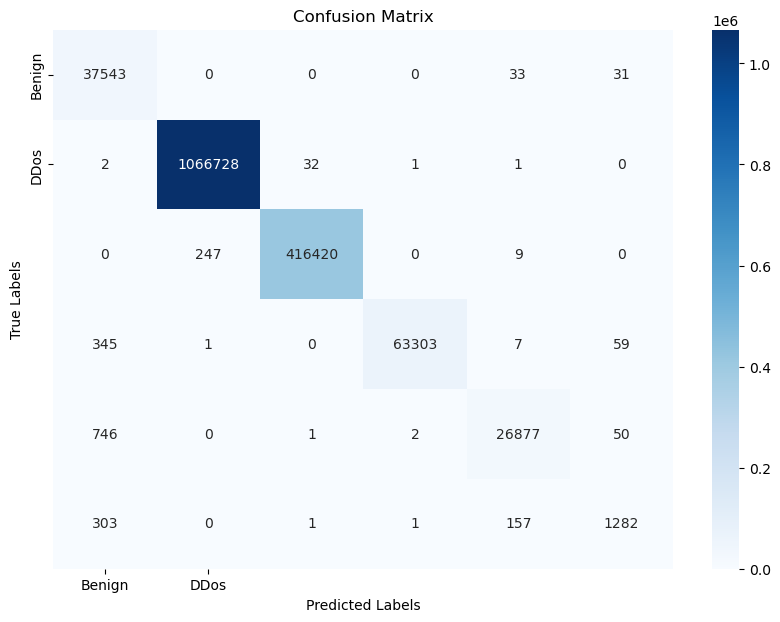

In [20]:
cm_rf_pso_6 = confusion_matrix(y_test_6, y_pred_rf_pso_6)

# get names for confusion matrix
df_6 = pd.DataFrame(rf_pso_report_6)
column_names_6 = df_6.columns.tolist()[0:2]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_pso_6,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_6,
            yticklabels=column_names_6)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 19 Classes

In [21]:
rf_pso_best_pos_19, rf_pso_best_fitness_19 = pso_feature_selection(X_train=X_train, X_test=X_test, y_train=y_train_19, y_test=y_test_19, parallel=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:   59.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   31.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Initialization time: 2.46 minutes
Iteration 1/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:   59.0s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   31.6s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9951
Iteration time: 2.50 minutes
Iteration 2/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   57.4s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   32.3s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9965
Iteration time: 2.74 minutes
Iteration 3/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.9min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.2min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   32.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9965
Iteration time: 2.73 minutes
Iteration 4/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.7min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  1.9min remaining:   50.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.0min remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9965
Iteration time: 2.69 minutes
Iteration 5/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  2.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.1min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:   59.1s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   32.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9967
Iteration time: 2.63 minutes
Iteration 6/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.8min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   55.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.32 minutes
Iteration 7/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.4min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.6min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  1.9min remaining:   51.2s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.0min remaining:   27.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.37 minutes
Iteration 8/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.8min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   55.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   30.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.26 minutes
Iteration 9/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   56.8s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   30.6s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.44 minutes
Iteration 10/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.8min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   56.7s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.6s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.40 minutes
Iteration 11/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   56.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.23 minutes
Iteration 12/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.5min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.6min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   53.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.0min remaining:   27.8s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.32 minutes
Iteration 13/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.7min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.1min remaining:   56.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.48 minutes
Iteration 14/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  2.0min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.2min remaining:   59.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.3min remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.75 minutes
Iteration 15/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  1.9min remaining:   51.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.1min remaining:   29.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Global Best Fitness: 0.9973
Iteration time: 2.40 minutes
Iteration 16/20


[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:  1.8min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.8min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  1.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  2.0min remaining:   54.7s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  2.2min remaining:   30.1s


Global Best Fitness: 0.9973
Iteration time: 2.71 minutes


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.7min finished


In [22]:
rf_pso_features_19 = np.sum(rf_pso_best_pos_19)
selected_features = np.where(rf_pso_best_pos_19 == 1)[0]
rf_pso_report_19, rf_pso_time_19, y_pred_rf_pso_19 = calculate_benchmark(X_train=X_train[:, selected_features], X_test=X_test[:, selected_features], y_train=y_train_19, y_test=y_test_19)
print(pd.DataFrame(rf_pso_report_19).transpose())
print(rf_pso_time_19)

                    precision    recall  f1-score       support
ARP_spoofing         0.881714  0.790711  0.833736  1.744000e+03
Benign               0.959850  0.998670  0.978875  3.760700e+04
DDoS_ICMP            0.999323  0.999963  0.999643  3.496990e+05
DDoS_SYN             0.999791  0.998880  0.999336  1.723970e+05
DDoS_TCP             0.999825  0.999836  0.999830  1.825980e+05
DDoS_UDP             0.999268  0.999478  0.999373  3.620700e+05
DDoS_connect_flood   0.999857  0.999881  0.999869  4.191600e+04
DDoS_publish_flood   0.998799  0.988474  0.993610  8.416000e+03
DoS_ICMP             0.999766  0.999086  0.999426  9.843200e+04
DoS_SYN              0.999716  0.999625  0.999670  9.859500e+04
DoS_TCP              0.999878  0.999890  0.999884  8.209600e+04
DoS_UDP              0.999731  0.999178  0.999455  1.375530e+05
DoS_connect_flood    0.999039  0.996487  0.997761  3.131000e+03
DoS_publish_flood    0.989529  1.000000  0.994737  8.505000e+03
Malformed_date       0.997604  0.714940 

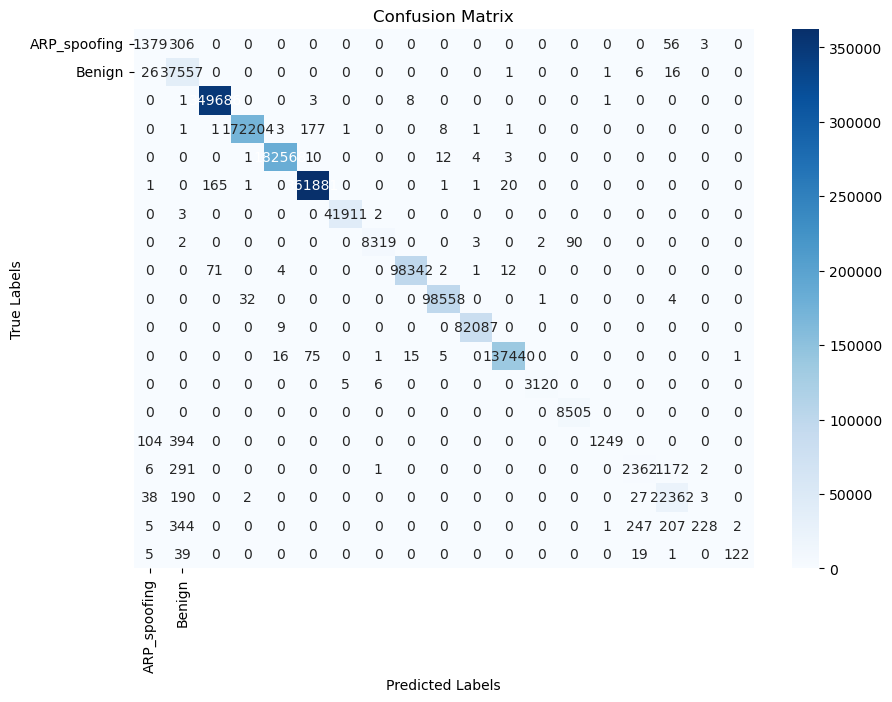

In [24]:
cm_rf_pso_19 = confusion_matrix(y_test_19, y_pred_rf_pso_19)

# get names for confusion matrix
df_19 = pd.DataFrame(rf_pso_report_19)
column_names_19 = df_19.columns.tolist()[0:2]

# visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_pso_19,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=column_names_19,
            yticklabels=column_names_19)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Results

In [25]:
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
results_folder = f"results_data_{current_datetime}"

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [26]:
data_to_save = {
    'rf_pso_report_2': rf_pso_report_2,
    'rf_pso_time_2': rf_pso_time_2,
    'rf_pso_features_2': rf_pso_features_2,
    'rf_pso_best_pos_2': rf_pso_best_pos_2,
    'rf_pso_report_6': rf_pso_report_6,
    'rf_pso_time_6': rf_pso_time_6,
    'rf_pso_features_6': rf_pso_features_6,
    'rf_pso_best_pos_6': rf_pso_best_pos_6,
    'rf_pso_report_19': rf_pso_report_19,
    'rf_pso_time_19': rf_pso_time_19,
    'rf_pso_features_19': rf_pso_features_19,
    'rf_pso_best_pos_19': rf_pso_best_pos_19,
    'cm_rf_pso_2': cm_rf_pso_2,
    'cm_rf_pso_6': cm_rf_pso_6,
    'cm_rf_pso_19': cm_rf_pso_19
}

In [27]:
for name, data in data_to_save.items():
    file_path = os.path.join(results_folder, f'{name}.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

In [28]:
for key in data_to_save:
    if isinstance(data_to_save[key], np.integer):
        data_to_save[key] = int(data_to_save[key])
    elif isinstance(data_to_save[key], np.ndarray):
        data_to_save[key] = data_to_save[key].tolist()
        
for name, data in data_to_save.items():
    file_path = os.path.join(results_folder, f'{name}.json') 
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

## Notebook Duration

In [29]:
notebook_end_time = time.time()
print(f"Notebook Duration: {(notebook_end_time - notebook_start_time) / 60} minutes")

Notebook Duration: 106.40062719583511 minutes
